In [1]:
from obspy import UTCDateTime
import obspy as obs
from obspy.clients.fdsn import Client as FDSN_Client
import numpy as np


In [2]:
t1 = UTCDateTime("2009-03-24")
t2 = UTCDateTime("2009-03-30")
stname = ['SND']
network = 'AZ'
org = 'IRIS'

client = FDSN_Client(org)


for i, comp in enumerate(['HHE', 'HHN', 'HHZ']):
  land_st1 = client.get_waveforms(network, str(stname[0]), "*", str(comp), t1, t2)
  if i==0:
    st=land_st1
  else:
    st+=land_st1

st_original = st.copy()
st = st_original.copy()
st.detrend()
st.taper(max_percentage=0.05)
st.filter('highpass', freq=2)



3 Trace(s) in Stream:
AZ.SND..HHE | 2009-03-24T00:00:00.000000Z - 2009-03-30T00:00:00.000000Z | 100.0 Hz, 51840001 samples
AZ.SND..HHN | 2009-03-24T00:00:00.000000Z - 2009-03-30T00:00:00.000000Z | 100.0 Hz, 51840001 samples
AZ.SND..HHZ | 2009-03-24T00:00:00.000000Z - 2009-03-30T00:00:00.000000Z | 100.0 Hz, 51840001 samples

In [ ]:
#Pick phases
import torch
import seisbench
import seisbench.models as sbm
import pandas as pd

#define models
picker = sbm.PickBlue("phasenet")

if torch.cuda.is_available():
    picker.cuda()

#Threshold of the probability of S and P phases to identify events
pmin=0.5
smin=0.5

picks = picker.classify(st, batch_size=256, P_threshold=pmin, S_threshold=smin).picks

    # convert the picks and station metadata into pandas dataframes
pick_df = []
pick_df_remain = []
for i,p in enumerate(picks):
    pick_df.append({
        "pick_idx":i,
        "id": p.trace_id,
        "timestamp": p.peak_time.datetime,
        "amp":0.0,
        "prob": p.peak_value,
        "type": p.phase.lower()
    })
pick_df = pd.DataFrame(pick_df)


2025-05-06 05:40:50,589 | seisbench | WARNING | You are processing a large stream with the sequential asyncio implementation. Consider activating parallelisation. For details, see http://docs.seisbench.org/en/stable/pages/documentation/models.html#seisbench.models.base.WaveformModel.annotate


In [8]:
print(pick_df)

     pick_idx       id               timestamp  amp      prob type
0           0  AZ.SND. 2009-03-24 00:37:57.180  0.0  0.535632    s
1           1  AZ.SND. 2009-03-24 00:52:48.800  0.0  0.685224    s
2           2  AZ.SND. 2009-03-24 01:23:25.400  0.0  0.619705    s
3           3  AZ.SND. 2009-03-24 01:57:32.100  0.0  0.622561    s
4           4  AZ.SND. 2009-03-24 02:24:54.080  0.0  0.562508    s
..        ...      ...                     ...  ...       ...  ...
626       626  AZ.SND. 2009-03-29 22:50:16.090  0.0  0.674696    s
627       627  AZ.SND. 2009-03-29 23:10:17.300  0.0  0.859697    s
628       628  AZ.SND. 2009-03-29 23:29:42.320  0.0  0.617466    s
629       629  AZ.SND. 2009-03-29 23:46:48.240  0.0  0.572149    s
630       630  AZ.SND. 2009-03-29 23:56:06.270  0.0  0.621203    s

[631 rows x 6 columns]


In [4]:

selected_times = np.random.choice(land_st1[0].times(), 100, replace=False)


In [5]:
import sys
sys.path.append("../")
from ground_motion_qh import extract_pairs

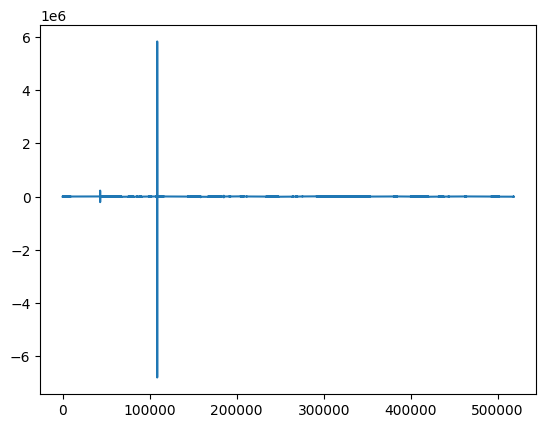

In [6]:
from matplotlib import pyplot as plt

plt.plot(
    land_st1[0].times(),
    land_st1[0].data
)

0.9

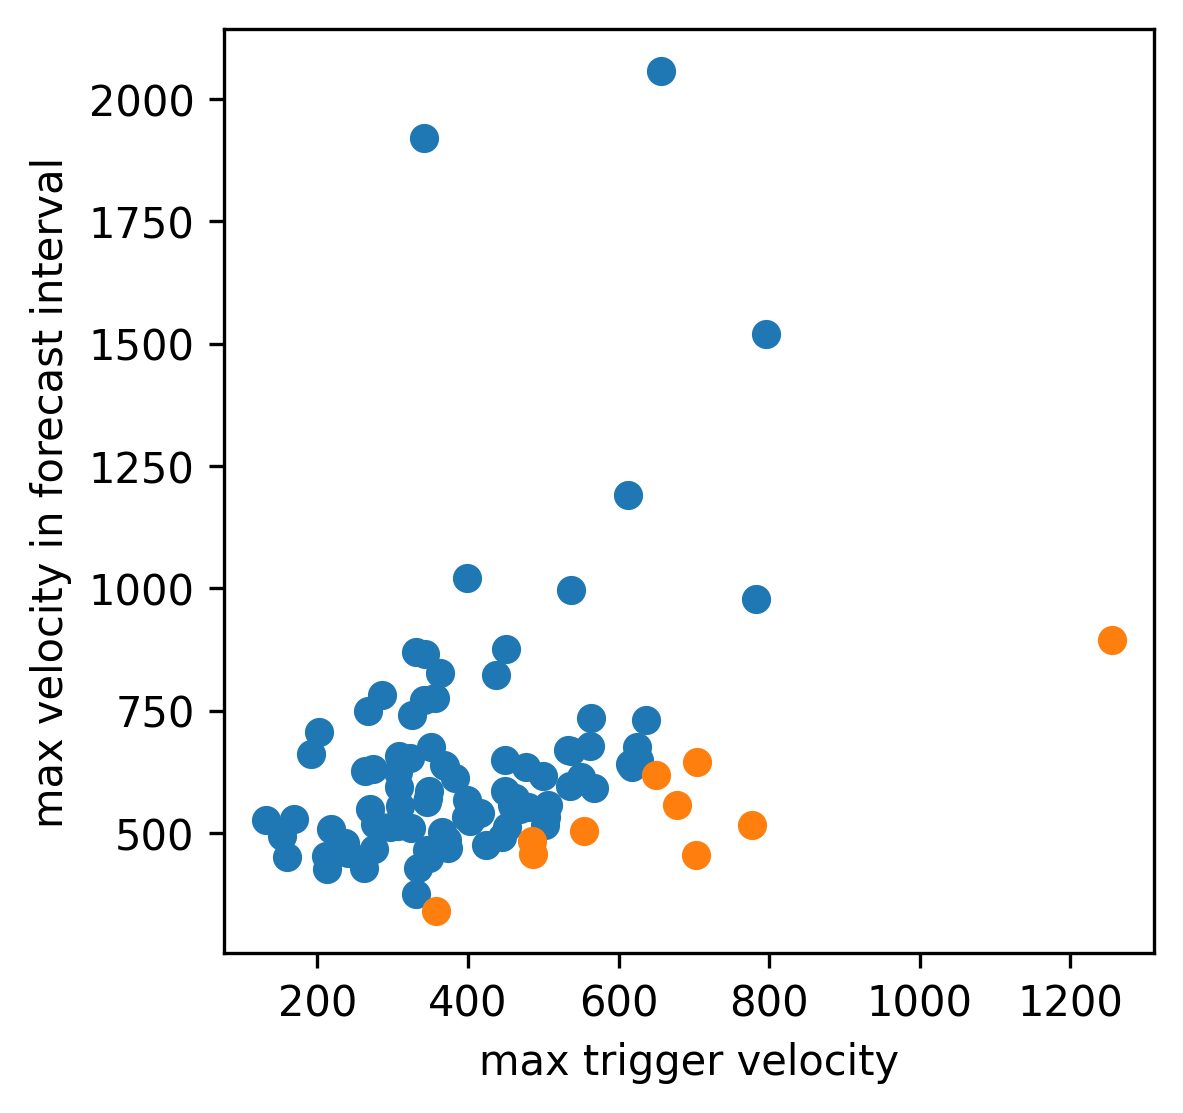

In [7]:

a_minus_vector, a_plus_vector = extract_pairs.waveform_to_max_amp_pairs(
    selected_times,
    land_st1[0].data,
    land_st1[0].times(),
    # tw_minus=TW_MINUS,
    # tw_plus=TW_PLUS,
    # tw_buffer=TW_BUFFER,
)
above_logical = a_plus_vector>a_minus_vector

fig, ax = plt.subplots(dpi=300, figsize = (4,4))
ax.scatter(a_minus_vector[above_logical], a_plus_vector[above_logical])
ax.scatter(a_minus_vector[~above_logical], a_plus_vector[~above_logical])
ax.set_xlabel('max trigger velocity')
ax.set_ylabel('max velocity in forecast interval')
np.mean(a_plus_vector>a_minus_vector)